In [1]:
!pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from lib import evaluate
from lib.serialize import iter_jl
import pandas as pd
import numpy as np

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
dict_genres = {'pop': 1, 'country': 2, 'blues': 3, 'rock': 4, 'jazz': 5, "reggae": 6, "hip hop": 7}

In [5]:
df = pd.read_csv('tcc_ceds_music.csv')

In [6]:
df['genre'] = df['genre'].apply(lambda x: dict_genres[x])
df["acousticness"] = np.cbrt(df["acousticness"]) # cube root transform

In [7]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,1,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.999330,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,1,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.984707,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,1,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.943674,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,1,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.437839,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,1,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.991902,0.000246,0.597073,0.394375,romantic,1.0


In [8]:
train, test = evaluate.date_split(df)

In [9]:
X_train, y_train = evaluate.x_y_split(train)
X_test, y_test = evaluate.x_y_split(test)

In [10]:
evaluate.to_json_lines(X_train,y_train,'train')
evaluate.to_json_lines(X_test,y_test,'test')

In [11]:
X_train, y_train = iter_jl('X_train.jl'), iter_jl('y_train.jl')

In [12]:
X_test, y_test = iter_jl('X_test.jl'), iter_jl('y_test.jl')

In [13]:
X_train = list(X_train)
y_train = list(y_train)
X_test = list(X_test)
y_test = list(y_test)

In [44]:
from lib.transformers import FeatureProjectionFromJson, TargetEncoder, PretrainedFastTextTransformer
from lib.transformers import TargetEncodeWithNumericalMean, TargetEncodeWithNumericalMaxOutlier, TargetEncodeWithNumericalMinOutlier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

fields = ['age','violence', 
                            'family/gospel','romantic','obscene','movement/places',
                           'light/visual perceptions','family/spiritual','sadness',
                           'danceability','loudness','acousticness','instrumentalness','valence','energy'] 

#saque algunos numericos: 'dating','like/girls','feelings', 'communication', 'world/life','night/time', 'music', 

features_pipe = make_union(make_pipeline(
        FeatureProjectionFromJson(fields)
),
                           #make_pipeline(FeatureProjectionFromJson(['topic']), OneHotEncoder()),
                           
                          make_pipeline(TargetEncodeWithNumericalMean('topic', fields)),
                        
                           make_pipeline(TargetEncodeWithNumericalMean('artist_name', fields)),
                           
                           make_pipeline(PretrainedFastTextTransformer('lyrics_fasttext.bin','lyrics')),
                           
                          )

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics_multi(y_true, y_pred):
    dicc = {'f1': f1_score(y_true, y_pred, average = 'macro'),
      'precision': precision_score(y_true, y_pred, average = 'macro'),
      'acc': accuracy_score(y_true, y_pred),
      'recall': recall_score(y_true, y_pred, average = 'macro')}
    #print(dicc)
    return(dicc)

In [16]:
import lightgbm as lgb
from pprint import pprint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time


def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['num_leaves'] = int(params['num_leaves'])
    params['max_bin'] = int(params['max_bin'])
    params['max_depth'] = int(params['max_depth'])
    print(params)
    pipe = make_pipeline(
        features_pipe,
        lgb.LGBMClassifier(random_state=42 ,class_weight = 'balanced', **params)
    )
    t0 = time()
    pipe.fit(X_train, y_train)
    train_time = time() - t0
    loss=-get_metrics_multi(y_test, pipe.predict(X_test))['f1']
    print(f'loss {loss:.02f}')
    return dict(
        loss=loss,
        tr_loss=-get_metrics_multi(y_train, pipe.predict(X_train))['f1'], 
        params=params,
        train_time=train_time,
        status=STATUS_OK
    )

In [17]:
import numpy as np

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 150, 10),
    'subsample': hp.quniform('subsample', 0.6, 0.9, 0.1),
    'reg_alpha': hp.choice('ra', [0, hp.quniform('reg_alpha', 0.01, 0.1, 0.01)]),
    'num_leaves': hp.quniform('num_leaves', 20, 50, 5),
    'max_bin' : hp.quniform('max_bin', 20, 60, 5),
    'max_depth':hp.quniform('max_depth', 5, 100, 10),
}

trials = Trials()

In [18]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=500, trials=trials)

{'max_bin': 35, 'max_depth': 60, 'n_estimators': 110, 'num_leaves': 25, 'reg_alpha': 0.04, 'subsample': 0.8}
  0%|                                   | 0/500 [00:00<?, ?trial/s, best loss=?]

loss -0.68                                                                      
{'max_bin': 20, 'max_depth': 50, 'n_estimators': 70, 'num_leaves': 35, 'reg_alpha': 0.04, 'subsample': 0.8}
loss -0.68                                                                      
{'max_bin': 35, 'max_depth': 20, 'n_estimators': 140, 'num_leaves': 35, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.69                                                                      
{'max_bin': 35, 'max_depth': 70, 'n_estimators': 150, 'num_leaves': 25, 'reg_alpha': 0.1, 'subsample': 0.8}
loss -0.69                                                                      
{'max_bin': 30, 'max_depth': 10, 'n_estimators': 80, 'num_leaves': 35, 'reg_alpha': 0.07, 'subsample': 0.7000000000000001}
loss -0.67                                                                      
{'max_bin': 50, 'max_depth': 10, 'n_estimators': 140, 'num_leaves': 45, 'reg_alpha': 0.02, 'subsample': 0.8}
loss -0.69                

loss -0.67                                                                      
{'max_bin': 50, 'max_depth': 100, 'n_estimators': 110, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.69                                                                      
{'max_bin': 30, 'max_depth': 80, 'n_estimators': 140, 'num_leaves': 35, 'reg_alpha': 0.09, 'subsample': 0.7000000000000001}
loss -0.69                                                                      
{'max_bin': 45, 'max_depth': 50, 'n_estimators': 10, 'num_leaves': 25, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.53                                                                      
{'max_bin': 55, 'max_depth': 40, 'n_estimators': 30, 'num_leaves': 30, 'reg_alpha': 0.08, 'subsample': 0.6000000000000001}
loss -0.62                                                                      
{'max_bin': 40, 'max_depth': 20, 'n_estimators': 90, 'num_leaves': 25, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.67      

loss -0.69                                                                      
{'max_bin': 50, 'max_depth': 20, 'n_estimators': 80, 'num_leaves': 20, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.66                                                                      
{'max_bin': 45, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.08, 'subsample': 0.6000000000000001}
loss -0.68                                                                      
{'max_bin': 40, 'max_depth': 20, 'n_estimators': 70, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.68                                                                      
{'max_bin': 50, 'max_depth': 20, 'n_estimators': 90, 'num_leaves': 40, 'reg_alpha': 0.04, 'subsample': 0.6000000000000001}
loss -0.69                                                                      
{'max_bin': 50, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 45, 'reg_alpha': 0.03, 'subsample': 0.600

loss -0.68                                                                      
{'max_bin': 55, 'max_depth': 50, 'n_estimators': 120, 'num_leaves': 30, 'reg_alpha': 0, 'subsample': 0.9}
loss -0.69                                                                      
{'max_bin': 40, 'max_depth': 20, 'n_estimators': 130, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.69                                                                      
{'max_bin': 45, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.68                                                                      
{'max_bin': 50, 'max_depth': 20, 'n_estimators': 90, 'num_leaves': 35, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.69                                                                      
{'max_bin': 35, 'max_depth': 30, 'n_estimators': 110, 'num_leaves': 25, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -

loss -0.69                                                                      
{'max_bin': 50, 'max_depth': 10, 'n_estimators': 150, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.69                                                                      
{'max_bin': 35, 'max_depth': 10, 'n_estimators': 150, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.68                                                                      
{'max_bin': 45, 'max_depth': 10, 'n_estimators': 140, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.69                                                                      
{'max_bin': 40, 'max_depth': 90, 'n_estimators': 140, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.68                                                                      
{'max_bin': 50, 'max_depth': 10, 'n_estimators': 150, 'num_leaves': 40, 'reg_alpha': 0.08, 'subsample': 0.70000

loss -0.69                                                                      
{'max_bin': 55, 'max_depth': 60, 'n_estimators': 150, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.68                                                                      
{'max_bin': 40, 'max_depth': 100, 'n_estimators': 140, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.68                                                                      
{'max_bin': 50, 'max_depth': 70, 'n_estimators': 140, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.69                                                                      
{'max_bin': 45, 'max_depth': 80, 'n_estimators': 120, 'num_leaves': 35, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.68                                                                      
{'max_bin': 40, 'max_depth': 60, 'n_estimators': 150, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss

loss -0.69                                                                      
{'max_bin': 40, 'max_depth': 10, 'n_estimators': 150, 'num_leaves': 35, 'reg_alpha': 0.09, 'subsample': 0.6000000000000001}
loss -0.68                                                                      
{'max_bin': 35, 'max_depth': 20, 'n_estimators': 140, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.68                                                                      
{'max_bin': 40, 'max_depth': 40, 'n_estimators': 130, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.68                                                                      
{'max_bin': 50, 'max_depth': 30, 'n_estimators': 150, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.68                                                                      
{'max_bin': 45, 'max_depth': 50, 'n_estimators': 120, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.8}
lo

{'max_bin': 35, 'max_depth': 90, 'n_estimators': 100, 'num_leaves': 35, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.68                                                                      
{'max_bin': 45, 'max_depth': 10, 'n_estimators': 140, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss -0.69                                                                      
{'max_bin': 40, 'max_depth': 10, 'n_estimators': 70, 'num_leaves': 50, 'reg_alpha': 0.1, 'subsample': 0.7000000000000001}
loss -0.68                                                                      
{'max_bin': 45, 'max_depth': 40, 'n_estimators': 90, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.69                                                                      
{'max_bin': 50, 'max_depth': 50, 'n_estimators': 50, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.9}
loss -0.68                                                                      
{'max_bin': 40, 'max_

{'max_bin': 45, 'max_depth': 50, 'n_estimators': 80, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.68                                                                      
{'max_bin': 50, 'max_depth': 60, 'n_estimators': 90, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.69                                                                      
{'max_bin': 45, 'max_depth': 60, 'n_estimators': 60, 'num_leaves': 35, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.68                                                                      
{'max_bin': 40, 'max_depth': 50, 'n_estimators': 70, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.68                                                                      
{'max_bin': 45, 'max_depth': 40, 'n_estimators': 100, 'num_leaves': 40, 'reg_alpha': 0.06, 'subsample': 0.9}
loss -0.69                                                                      
{'max_bin': 50, 'max_

{'max_bin': 45, 'max_depth': 30, 'n_estimators': 120, 'num_leaves': 35, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.68                                                                      
{'max_bin': 45, 'max_depth': 40, 'n_estimators': 140, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.69                                                                      
{'max_bin': 50, 'max_depth': 20, 'n_estimators': 80, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.68                                                                      
{'max_bin': 45, 'max_depth': 60, 'n_estimators': 130, 'num_leaves': 45, 'reg_alpha': 0.09, 'subsample': 0.7000000000000001}
loss -0.69                                                                      
{'max_bin': 35, 'max_depth': 70, 'n_estimators': 140, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.9}
loss -0.69                                                                      
{'max_bin': 40, 'max_depth': 10, 'n_estimators':

loss -0.69                                                                      
{'max_bin': 45, 'max_depth': 60, 'n_estimators': 100, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.68                                                                      
{'max_bin': 45, 'max_depth': 50, 'n_estimators': 110, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.70                                                                      
{'max_bin': 40, 'max_depth': 40, 'n_estimators': 110, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.68                                                                      
{'max_bin': 50, 'max_depth': 50, 'n_estimators': 110, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss -0.69                                                                      
{'max_bin': 45, 'max_depth': 40, 'n_estimators': 120, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.60000000

loss -0.69                                                                      
{'max_bin': 45, 'max_depth': 40, 'n_estimators': 80, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.68                                                                      
{'max_bin': 40, 'max_depth': 40, 'n_estimators': 90, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.69                                                                      
{'max_bin': 50, 'max_depth': 50, 'n_estimators': 110, 'num_leaves': 50, 'reg_alpha': 0.03, 'subsample': 0.8}
loss -0.69                                                                      
{'max_bin': 55, 'max_depth': 30, 'n_estimators': 100, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.68                                                                      
{'max_bin': 40, 'max_depth': 40, 'n_estimators': 90, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.9}
loss -0.69                                                       

{'max_bin': 45, 'max_depth': 50, 'n_estimators': 120, 'num_leaves': 45, 'reg_alpha': 0, 'subsample': 0.8}
loss -0.69                                                                      
{'max_bin': 50, 'max_depth': 50, 'n_estimators': 110, 'num_leaves': 45, 'reg_alpha': 0.09, 'subsample': 0.9}
loss -0.69                                                                      
{'max_bin': 40, 'max_depth': 30, 'n_estimators': 110, 'num_leaves': 50, 'reg_alpha': 0, 'subsample': 0.9}
loss -0.68                                                                      
100%|████| 500/500 [1:25:08<00:00, 10.22s/trial, best loss: -0.6970025500350248]


In [21]:
def flatten(doc, pref=''):
    res = {}
    for k, v in doc.items():
        k = f'{pref}.{k}' if pref else k
        if isinstance(v, dict):
            res.update(flatten(v, k))
        else:
            res[k] = v
    return res

In [27]:
import pandas as pd
df = pd.DataFrame(list(map(flatten, [e['result'] for e in trials.trials])))
df.sort_values('loss').head()

,loss,tr_loss,params.max_bin,params.max_depth,params.n_estimators,params.num_leaves,params.reg_alpha,params.subsample,train_time,status
446,-0.697003,-0.99162,45,40,100,45,0.0,0.8,6.239944,ok
421,-0.697003,-0.99162,45,40,100,45,0.0,0.7,8.642848,ok
409,-0.697003,-0.99162,45,40,100,45,0.0,0.6,6.250602,ok
459,-0.697003,-0.99162,45,50,100,45,0.0,0.8,6.691869,ok
338,-0.697003,-0.99162,45,30,100,45,0.0,0.8,6.418199,ok


In [28]:
df.tr_loss = df.tr_loss * -1
df.loss = df.loss * -1

In [29]:
df.head()

,loss,tr_loss,params.max_bin,params.max_depth,params.n_estimators,params.num_leaves,params.reg_alpha,params.subsample,train_time,status
0,0.677669,0.947394,35,60,110,25,0.04,0.8,7.852132,ok
1,0.675558,0.930647,20,50,70,35,0.04,0.8,5.449517,ok
2,0.691303,0.992448,35,20,140,35,0.00,0.7,7.147416,ok
3,0.685674,0.975495,35,70,150,25,0.10,0.8,6.456426,ok
4,0.673884,0.946282,30,10,80,35,0.07,0.7,5.328492,ok


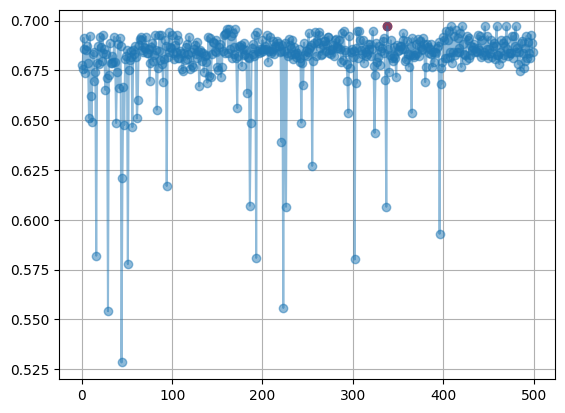

In [30]:
import matplotlib.pyplot as plt

df.loss.plot(style='-o', alpha=0.5)
plt.scatter([df.loss.argmax()], [df.loss.max()], c='r')
#df.tr_loss.plot()
#plt.yscale('log')
plt.grid()

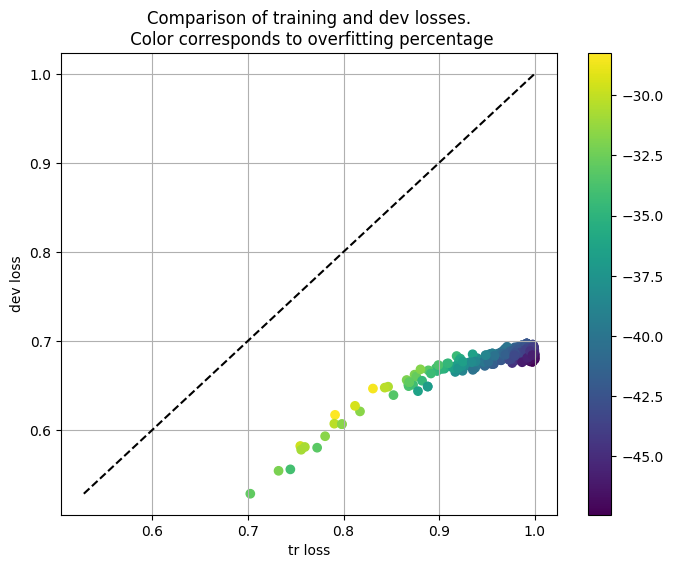

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(df.tr_loss, df.loss, c=(df.loss-df.tr_loss)/df.loss*100)
plt.title('Comparison of training and dev losses.\n Color corresponds to overfitting percentage')
plt.colorbar()
m = min(df.tr_loss.min(), df.loss.min())
M = max(df.tr_loss.max(), df.loss.max())
plt.plot([m, M], [m, M], 'k--')
plt.xlabel('tr loss')
plt.ylabel('dev loss')
plt.grid()

In [32]:
cut_point = df.loss.median()
best_models_df = df[df.loss <= cut_point]
worst_models_df = df[df.loss > cut_point]


def visualize_param(param_name):
  s = df[f'params.{param_name}']
  if s.dtype.name == 'object':
    visualize_categorical_param(param_name)
  else: # assume numerical
    visualize_numerical_param(param_name)

def visualize_categorical_param(param_name):
    pd.concat([
      best_models_df[f'params.{param_name}'].value_counts().rename('best'),
      worst_models_df[f'params.{param_name}'].value_counts().rename('worst')
  ], axis=1).plot.bar()

def visualize_numerical_param(param_name):
  plt.violinplot([
      best_models_df[f'params.{param_name}'],
      worst_models_df[f'params.{param_name}']
  ])
  plt.xticks([1, 2], ['best', 'worst'])

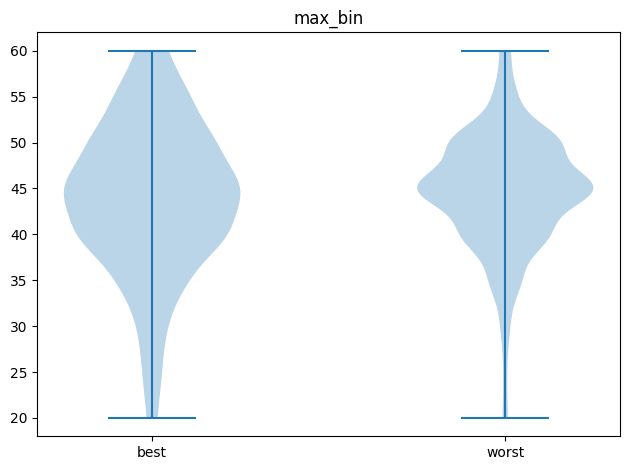

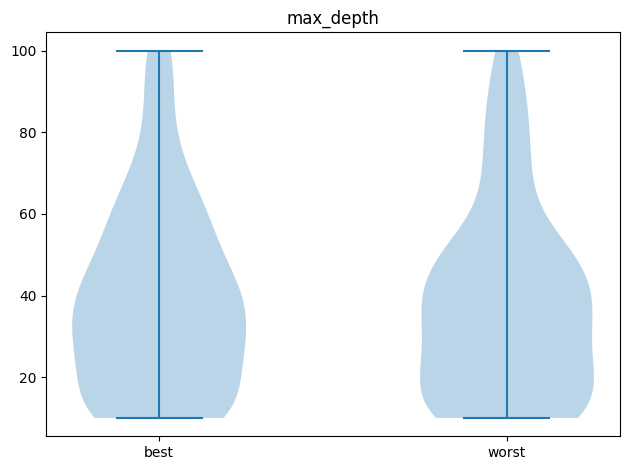

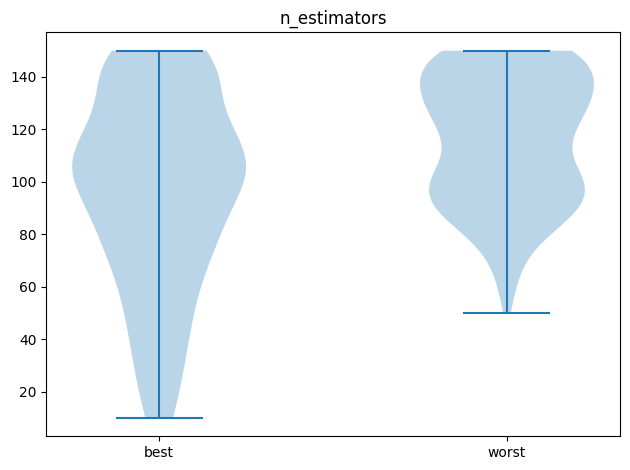

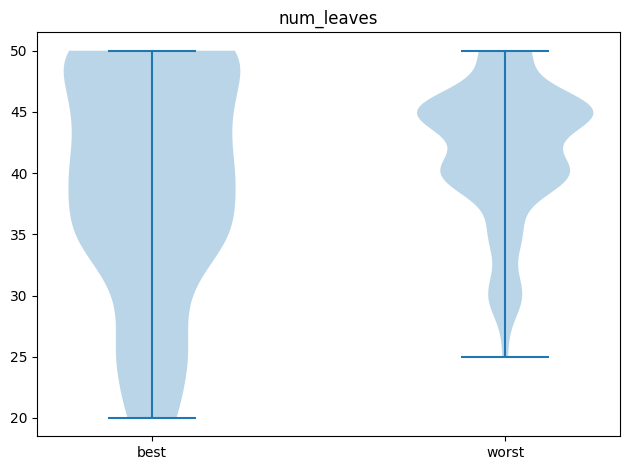

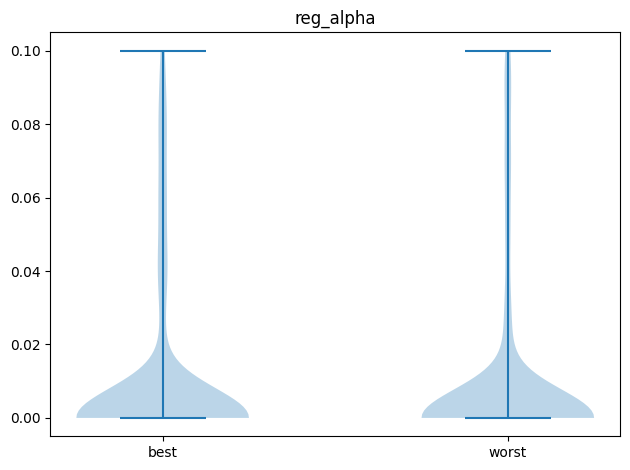

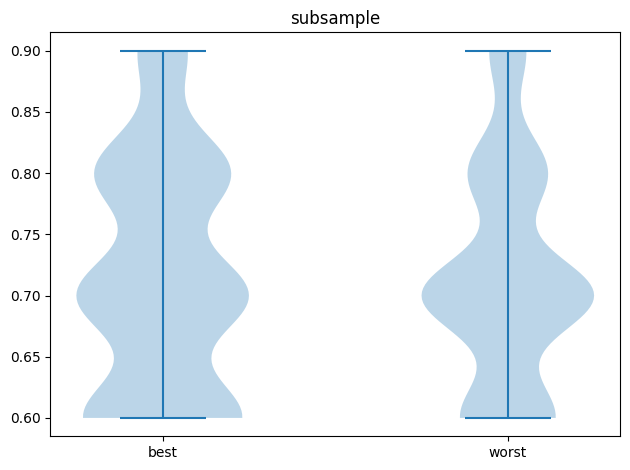

In [33]:

param_names = list(trials.trials[0]['result']['params'].keys())
for param_name in param_names:
  plt.figure()
  visualize_param(param_name)
  plt.title(param_name)
  plt.tight_layout()

In [34]:
# El que menos overfittea de los mejors
best = df[df.loss > df.loss.max() * 0.99].sort_values('tr_loss', ascending=True).head(30)
best

,loss,tr_loss,params.max_bin,params.max_depth,params.n_estimators,params.num_leaves,params.reg_alpha,params.subsample,train_time,status
334,0.691192,0.968935,45,30,80,40,0.00,0.6,5.566136,ok
356,0.693513,0.971063,30,10,90,40,0.00,0.8,5.595173,ok
66,0.690371,0.976756,45,50,120,30,0.00,0.6,6.094757,ok
149,0.690234,0.978240,45,20,80,45,0.00,0.6,5.646346,ok
86,0.692815,0.979111,50,20,90,40,0.04,0.6,5.937254,ok
464,0.690182,0.979218,45,50,80,45,0.00,0.9,6.166604,ok
405,0.690182,0.979218,45,40,80,45,0.00,0.6,6.664826,ok
401,0.690182,0.979218,45,50,80,45,0.00,0.6,5.819291,ok
311,0.690182,0.979218,45,40,80,45,0.00,0.6,5.774780,ok
23,0.692868,0.981759,45,40,130,30,0.00,0.6,6.314945,ok


In [35]:
params = {k.replace('params.', ''):v for k, v in best.iloc[0].to_dict().items() if 'params.' in k}
rf_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMClassifier(random_state=42, class_weight = 'balanced', **params)
)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureprojectionfromjson',
                                                                  FeatureProjectionFromJson(fields=['age',
                                                                                                    'violence',
                                                                                                    'family/gospel',
                                                                                                    'romantic',
                                                                                                    'obscene',
                                                                                                    'movement/places',
                                                                                                    'light/visual '
                                                                                                    'perceptions',
                                                                                                    'family/spiritual',
                                                                                                    'sadness',
                                                                                                    'danceability',
                                                                                                    'loudness',
                                                                                                    'acousticness',
                                                                                                    'instrumentalness',
                                                                                                    'vale...
                                                                                                                  'acousticness',
                                                                                                                  'instrumentalness',
                                                                                                                  'valence',
                                                                                                                  'energy']))])),
                                                ('pipeline-4',
                                                 Pipeline(steps=[('pretrainedfasttexttransformer',
                                                                  PretrainedFastTextTransformer(field='lyrics',
                                                                                                fname='lyrics_fasttext.bin'))]))])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', max_bin=45,
                                max_depth=30, n_estimators=80, num_leaves=40,
                                random_state=42,
                                subsample=0.6000000000000001))])

## Análisis de error.

In [36]:
preds = rf_pipe.predict(X_test)

In [37]:
preds

array([1, 5, 1, ..., 7, 7, 1])

In [38]:
get_metrics_multi(y_true=y_test, y_pred=preds)

{'f1': 0.6911916975737945,
 'precision': 0.7119281267100718,
 'acc': 0.6899159663865546,
 'recall': 0.6852718960569196}

In [41]:
def get_confused_with(trueCategory,predictedCategory, preds, y_test):
    indexes = []
    for i,(pred,true) in enumerate(zip(preds,y_test)):
        if pred == predictedCategory and true == trueCategory:
            indexes.append(i)
    return indexes

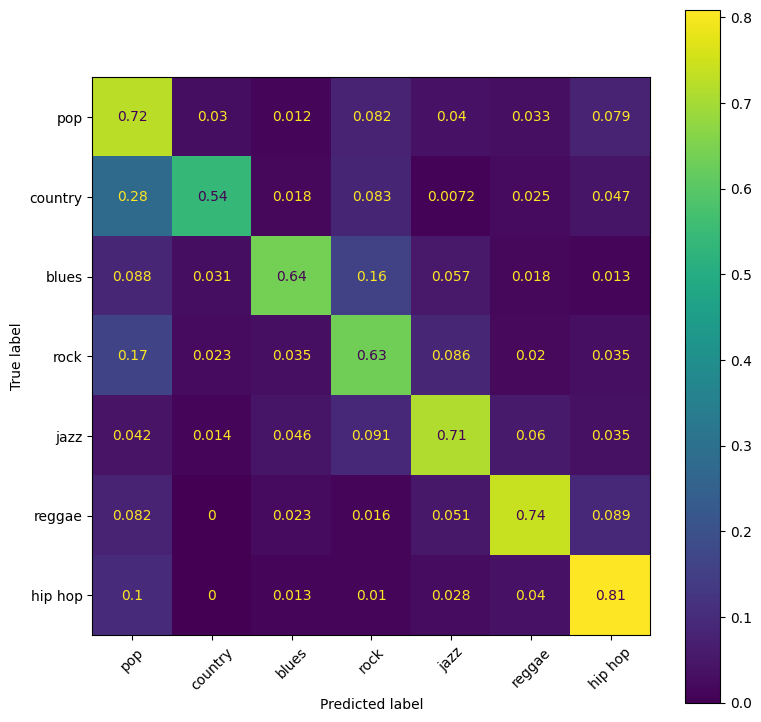

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)

### Observamos que country se confunde mucho con pop.

In [43]:
test.iloc[get_confused_with(2,1, preds, y_test)]

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
12211,38224,charles kelley,lonely girl,2016,2,matter cry wasn dream gotta tell wasn good lon...,64,0.000849,0.000849,0.000849,...,0.372014,0.022126,0.779053,0.757916,0.418491,0.000000,0.739283,0.663653,sadness,0.057143
12225,38307,cole swindell,party wasn't over,2016,2,little blue buzz bare foot say hop truck right...,157,0.000381,0.000381,0.000381,...,0.056161,0.072617,0.449800,0.821834,0.410901,0.000000,0.539365,0.909907,obscene,0.057143
12226,38313,brothers osborne,pawn shop,2016,2,bill need cash like yesterday junk lay credit ...,105,0.001196,0.001196,0.170479,...,0.001196,0.001196,0.626340,0.759762,0.435381,0.000022,0.975268,0.885882,obscene,0.057143
12235,38358,gary allan,do you wish it was me?,2016,2,elevate plateau try sense mind state life know...,110,0.000598,0.000598,0.399001,...,0.000598,0.136371,0.600347,0.745199,0.622277,0.000007,0.454864,0.592580,world/life,0.057143
12240,38382,ty march.,mr. right now,2016,2,know go like girl felt like watch heart bleed ...,114,0.145822,0.070641,0.038730,...,0.070873,0.048724,0.605762,0.763762,0.663556,0.000000,0.761954,0.807802,obscene,0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12467,39619,maren morris,the bones,2019,2,homestretch hard time take hard leave alright ...,126,0.058066,0.498038,0.000478,...,0.000478,0.104683,0.596014,0.743917,0.654307,0.000000,0.320899,0.570557,violence,0.014286
12474,39647,chris janson,waitin' on 5,2019,2,underneath turn wrench farm fix fence like wat...,137,0.000511,0.000511,0.000511,...,0.000511,0.062858,0.518033,0.839217,0.407302,0.000000,0.867065,0.896894,obscene,0.014286
12477,39668,jackson michelson,one at a time,2019,2,gonna pick twolane drive fast gear slide gonna...,119,0.000548,0.153828,0.000548,...,0.000548,0.000548,0.683743,0.813527,0.500667,0.000008,0.939200,0.845841,night/time,0.014286
12478,39672,kane brown,live forever,2019,2,life breathin like movie sound turn felt nothi...,77,0.000741,0.000741,0.334113,...,0.000741,0.000741,0.701072,0.704330,0.883553,0.000000,0.333265,0.392373,world/life,0.014286


### Observamos que rock se confunde mucho con pop.


In [46]:
test.iloc[get_confused_with(4,1, preds, y_test)]

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
27121,79929,frankie cosmos,fool,2016,4,triangle heart square intrigue leave wait feel...,34,0.001754,0.001754,0.001754,...,0.305506,0.090151,0.486624,0.651309,0.671071,0.000072,0.328112,0.436419,sadness,0.057143
27127,79948,ingrid michaelson,the lotto,2016,4,money gotta lotto cause gotta love free simple...,106,0.000578,0.000578,0.068508,...,0.000578,0.000578,0.677245,0.797810,0.622277,0.000000,0.874279,0.748741,obscene,0.057143
27134,79969,green day,bang bang,2016,4,kick wanna start rager wanna dance like video ...,39,0.002288,0.300276,0.002288,...,0.106879,0.002288,0.473627,0.775325,0.068845,0.000002,0.345631,0.958958,violence,0.057143
27136,79977,american authors,what we live for,2016,4,drive beatup caravan color blue remind eye pla...,96,0.043537,0.000693,0.417961,...,0.000693,0.000693,0.679411,0.791939,0.382181,0.000000,0.574402,0.902900,world/life,0.057143
27137,79981,the lumineers,white lie,2016,4,hand ask deny tell lie come true steal believe...,36,0.001548,0.318523,0.136347,...,0.001548,0.001548,0.617676,0.675281,0.926450,0.000713,0.147774,0.284262,violence,0.057143
27145,80022,car seat headrest,(joe gets kicked out of school for using) drug...,2016,4,know weekend weak hangovers feel good know fee...,187,0.000387,0.000387,0.000387,...,0.055043,0.061406,0.405394,0.716740,0.694750,0.000853,0.388912,0.452435,obscene,0.057143
27147,80030,die antwoord,banana brain,2016,4,banana brain apple stay tonight cause have bes...,79,0.021794,0.070420,0.117862,...,0.033864,0.001032,0.734647,0.769043,0.219956,0.015789,0.237428,0.930929,night/time,0.057143
27158,80068,a r i z o n a,let me touch your fire,2016,4,cold heart cold hand wanna know plan know norm...,56,0.052658,0.169895,0.000993,...,0.331139,0.000993,0.690242,0.726739,0.774095,0.000122,0.316777,0.511496,sadness,0.057143
27162,80072,the struts,put your money on me,2016,4,true baby sleep noon breakfast little smoke ho...,134,0.031231,0.000462,0.000462,...,0.000462,0.000462,0.545110,0.822552,0.100433,0.000000,0.680544,0.905903,obscene,0.057143
27177,80108,twenty one pilots,cancer,2016,4,turn away drink water cause lips chap fade aun...,39,0.001645,0.073306,0.001645,...,0.402099,0.001645,0.639337,0.631028,0.655866,0.000010,0.177659,0.295273,sadness,0.057143



### Observamos que el blues se confunde mucho con el rock.


In [45]:
test.iloc[get_confused_with(3,4, preds, y_test)]

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
16706,53232,radio moscow,250 miles/brain cycles,2016,3,recall suggest face heel drag halo pompeii eru...,113,0.001284,0.480733,0.001284,...,0.105270,0.001284,0.157370,0.660872,0.273153,0.697368,0.433223,0.645635,violence,0.057143
16746,53376,the bones of j.r. jones,hammers and nails,2016,3,sing song holler scream fruit bleed fruit blee...,72,0.001645,0.709945,0.001645,...,0.001645,0.001645,0.568938,0.768197,0.322793,0.003198,0.557914,0.747740,violence,0.057143
16749,53383,little hurricane,haunted heart,2016,3,thief night steal church pray heal lover steal...,39,0.001595,0.312108,0.256018,...,0.146719,0.001595,0.560273,0.742635,0.130607,0.000806,0.639324,0.720712,violence,0.057143
16761,53416,dorothy,wicked ones,2016,3,night faint heart faint heart faint heart nigh...,35,0.001949,0.260321,0.001949,...,0.363309,0.001949,0.568938,0.773966,0.328474,0.000000,0.584707,0.635624,sadness,0.057143
16769,53442,dorothy,raise hell,2016,3,gotta raise little hell young blood like river...,120,0.041756,0.402777,0.000474,...,0.000474,0.064296,0.525615,0.750019,0.282265,0.000000,0.713520,0.693684,violence,0.057143
16776,53473,robert randolph & the family band,got soul,2016,3,wiedersehen wiedersehen meet sweetheart lovely...,16,0.067810,0.004785,0.004785,...,0.179391,0.004785,0.600347,0.798708,0.107548,0.000112,0.522877,0.808803,romantic,0.057143
16785,53508,jamie n commons,glory,2016,3,truth tell know search sign line right wrong a...,54,0.001645,0.249000,0.135560,...,0.001645,0.030261,0.511535,0.799708,0.297779,0.038462,0.376546,0.734726,music,0.057143
16788,53515,benjamin booker,right on you,2017,3,start selfish damn want right think right righ...,51,0.001096,0.062129,0.042562,...,0.001096,0.001096,0.290588,0.678435,0.196257,0.000342,0.243611,0.892890,night/time,0.042857
16790,53527,goodbye june,good side,2017,3,time time want knife want decent life color ge...,120,0.000526,0.328806,0.000526,...,0.000526,0.083609,0.427055,0.803759,0.141453,0.002460,0.385820,0.919917,violence,0.042857
16795,53544,albert castiglia,hoodoo on me,2017,3,breathe like smoke taste cuban toke best years...,61,0.000975,0.112456,0.034644,...,0.000975,0.000975,0.445467,0.693049,0.097846,0.566802,0.760923,0.729721,night/time,0.042857


### Performance con artistas desconocidos o con pocas canciones

In [47]:
unseen_artists_test = test[~test['artist_name'].isin(train['artist_name'].unique())].copy()
X_unseen_artists_test, y_unseen_artists_test = evaluate.x_y_split(unseen_artists_test)
evaluate.to_json_lines(X_unseen_artists_test,y_unseen_artists_test,'unseen_artists_test')
X_unseen_artists_test, y_unseen_artists_test = list(iter_jl('X_unseen_artists_test.jl')), list(iter_jl('y_unseen_artists_test.jl'))

In [48]:
unseen_artists_preds = rf_pipe.predict(X_unseen_artists_test)

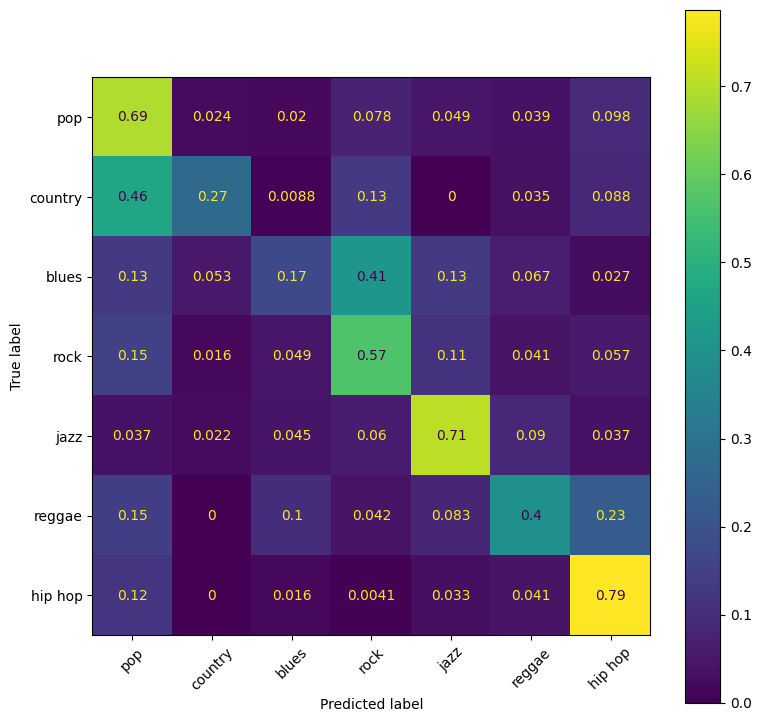

In [49]:
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_unseen_artists_test, unseen_artists_preds, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)